### Packages

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from tpot import TPOTRegressor

### Main Code Block

In [10]:
# Load the dataset
data = pd.read_csv('data/merged.csv', infer_datetime_format=True, low_memory = False)

# Drop columns with many unique options
data = data.drop(columns = ['Unnamed: 0', 'Non Use Code', 'Assessor Remarks', 'Location', 'OPM remarks'])

# Separate numerical and categorical features
numerical_features = data.select_dtypes(include=['number']).columns
categorical_features = data.select_dtypes(exclude=['number']).columns

# Impute missing values for numerical features
imputer = SimpleImputer(strategy='median')
data[numerical_features] = imputer.fit_transform(data[numerical_features])

# Impute missing values for categorical features
imputer = SimpleImputer(strategy='most_frequent')
data[categorical_features] = imputer.fit_transform(data[categorical_features])

# Encode high-cardinality categorical variables using target encoding
encoder = TargetEncoder(cols=['Town', 'Address', 'Property Type', 'Residential Type'])
data[categorical_features] = encoder.fit_transform(data[categorical_features], data['Sale Amount'])

# Define features (X) and target (y)
X = data.drop(columns='Sale Amount')  # Features
y = data['Sale Amount']  # Target variable

Year                         float64
Month                        float64
Town                         float64
Address                      float64
Assessed Value               float64
Sale Amount                  float64
Sales Ratio                  float64
Property Type                float64
Residential Type             float64
Val_monthly_household_est    float64
Val_new_construction         float64
Val_new_home_sales           float64
Vacant                       float64
Occupied                     float64
dtype: object 

Year                         997211
Month                        997211
Town                         997211
Address                      997211
Assessed Value               997211
Sale Amount                  997211
Sales Ratio                  997211
Property Type                997211
Residential Type             997211
Val_monthly_household_est    997211
Val_new_construction         997211
Val_new_home_sales           997211
Vacant                       99721

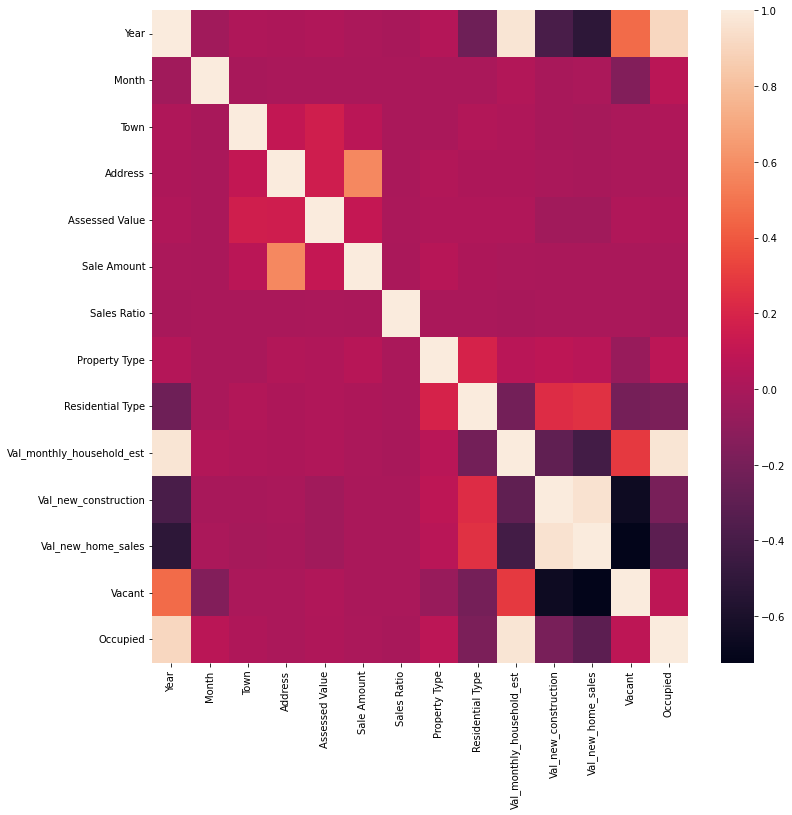

In [13]:
print(data.dtypes, '\n')
print(data.count(), '\n')
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12,12))
ax = sns.heatmap(corr_matrix)

In [14]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
trained_models = {}
validation_scores = {}

# Define models to test
models = {
    'CatBoost Regression': CatBoostRegressor(iterations=100, border_count=254, random_state=25, depth=8),
    'Decision Tree': DecisionTreeRegressor(max_depth=6, min_samples_leaf=17, min_samples_split=5),
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=10, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=10, random_state=42)
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_val_hat = model.predict(X_val)
    validation_score = r2_score(y_val, y_val_hat)
    validation_scores[model_name] = validation_score
    trained_models[model_name] = model
    print(f"Validation R-squared for {model_name}: {validation_score}")
    print()

best_model_name = max(validation_scores, key=validation_scores.get)
best_model = trained_models[best_model_name]

# 3. Test Set Evaluation for the Best Model
y_test_hat = best_model.predict(X_test)
test_score = r2_score(y_test, y_test_hat)

print(f"\nBest performing model on validation set: {best_model_name}")
print(f"Test R-squared for {best_model_name}: {test_score}")

Training CatBoost Regression...
Learning rate set to 0.5
0:	learn: 5507739.1657212	total: 284ms	remaining: 28.1s
1:	learn: 4869517.2327818	total: 401ms	remaining: 19.6s
2:	learn: 4325467.0595543	total: 496ms	remaining: 16s
3:	learn: 3854951.0995410	total: 623ms	remaining: 14.9s
4:	learn: 3408558.1994630	total: 759ms	remaining: 14.4s
5:	learn: 3061271.8862423	total: 933ms	remaining: 14.6s
6:	learn: 2838309.0605673	total: 1.15s	remaining: 15.3s
7:	learn: 2583051.2452145	total: 1.32s	remaining: 15.1s
8:	learn: 2283386.1353102	total: 1.47s	remaining: 14.9s
9:	learn: 2094460.4468103	total: 1.63s	remaining: 14.7s
10:	learn: 1940306.2607204	total: 1.78s	remaining: 14.4s
11:	learn: 1733546.0112935	total: 1.89s	remaining: 13.9s
12:	learn: 1622112.3309990	total: 1.99s	remaining: 13.3s
13:	learn: 1533469.6986683	total: 2.12s	remaining: 13s
14:	learn: 1461289.8321574	total: 2.23s	remaining: 12.7s
15:	learn: 1305530.1096101	total: 2.35s	remaining: 12.4s
16:	learn: 1254483.3183163	total: 2.43s	remai

### Feature Selection Work (Old)

In [15]:
# Loading the dataset
data = pd.read_csv('data/merged.csv', infer_datetime_format=True)

# Feature Selection Testing
data_full = data.drop(columns= 'Unnamed: 0')
data_pruned = data.drop(columns= ['Unnamed: 0', 'Non Use Code', 'Assessor Remarks', 'Location', 'OPM remarks', 'Town', 'Address'])
data_max_prune = data.drop(columns= ['Unnamed: 0', 'Non Use Code', 'Assessor Remarks', 'Location', 'Property Type', 'Residential Type', 'OPM remarks'])

# Removing Null Values From Data (Could Look Into Mean/Median/Mode Replacement)
data_dropped = data_full.dropna()
data_pruned_dropped = data_pruned.dropna()
data_max_prune_dropped = data_max_prune.dropna()

/tmp/ipykernel_933/2854909880.py:2: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/merged.csv', infer_datetime_format=True)


### Analyzing Feature Types (Old)

In [16]:
print('Full Data')
print(data_full.dtypes, '\n')

print('Data Pruned')
print(data_dropped.dtypes, '\n')

print('Data Pruned NA-Dropped')
print(data_pruned_dropped.dtypes, '\n')

print('Data Max Prune NA-Dropped')
print(data_max_prune_dropped.dtypes, '\n')

Full Data
Year                           int64
Month                          int64
Town                          object
Address                       object
Assessed Value               float64
Sale Amount                  float64
Sales Ratio                  float64
Property Type                 object
Residential Type              object
Non Use Code                  object
Assessor Remarks              object
OPM remarks                   object
Location                      object
Val_monthly_household_est    float64
Val_new_construction         float64
Val_new_home_sales           float64
Vacant                       float64
Occupied                     float64
dtype: object 

Data Pruned
Year                           int64
Month                          int64
Town                          object
Address                       object
Assessed Value               float64
Sale Amount                  float64
Sales Ratio                  float64
Property Type                 object


### Analyzing Feature Counts (Old)

In [17]:
print('Full Data')
print(data_full.count(), '\n')

print('Data Pruned')
print(data_dropped.count(), '\n')

print('Data Pruned NA-Dropped')
print(data_pruned_dropped.count(), '\n')

print('Data Max Prune NA-Dropped')
print(data_max_prune_dropped.count(), '\n')

Full Data
Year                         997211
Month                        997211
Town                         997211
Address                      997162
Assessed Value               997211
Sale Amount                  997211
Sales Ratio                  997211
Property Type                614767
Residential Type             608904
Non Use Code                 289681
Assessor Remarks             149864
OPM remarks                    9934
Location                     197697
Val_monthly_household_est    997211
Val_new_construction         997211
Val_new_home_sales           997211
Vacant                       997210
Occupied                     997210
dtype: int64 

Data Pruned
Year                         264
Month                        264
Town                         264
Address                      264
Assessed Value               264
Sale Amount                  264
Sales Ratio                  264
Property Type                264
Residential Type             264
Non Use Code      

### Correlation Matrix For Feature Selection Analysis (Old)

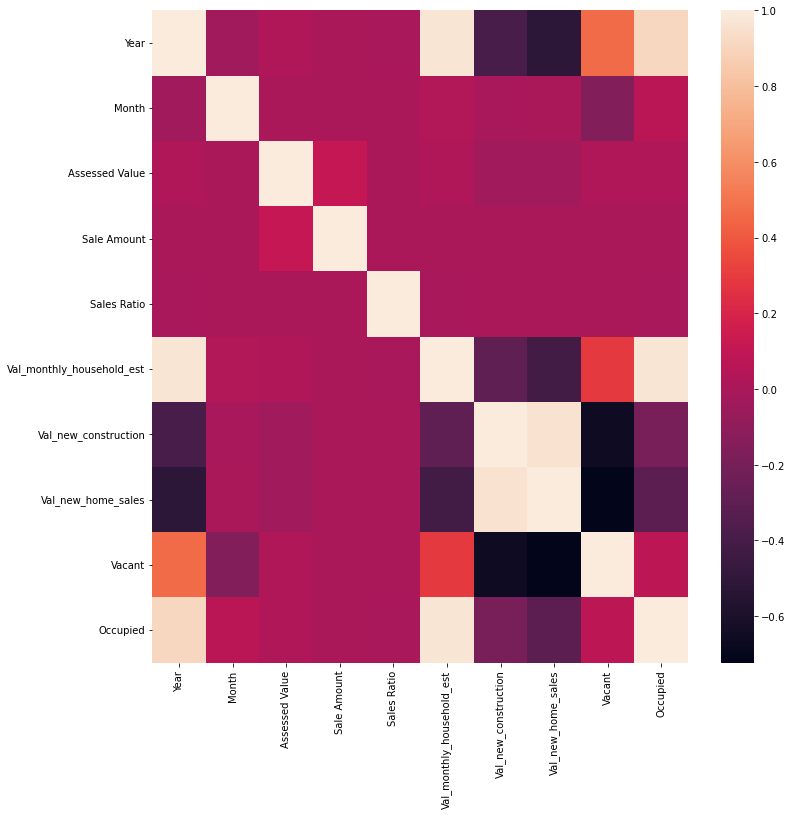

In [18]:
corr_matrix = data_pruned.corr(numeric_only=True)
plt.figure(figsize=(12,12))
ax = sns.heatmap(corr_matrix)

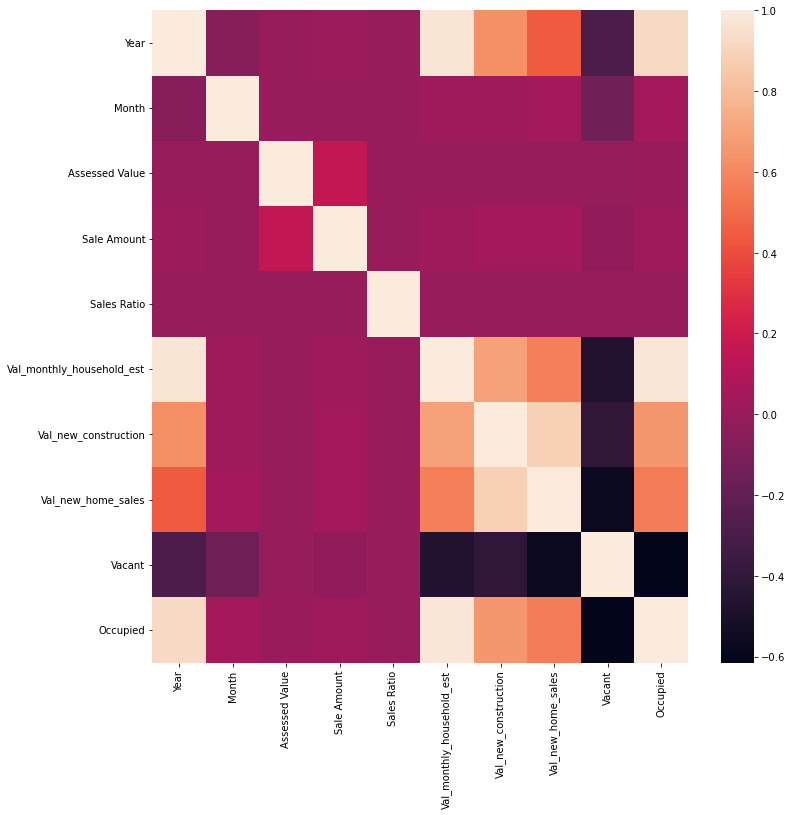

In [19]:
corr_matrix = data_pruned_dropped.corr(numeric_only=True)
plt.figure(figsize=(12,12))
ax = sns.heatmap(corr_matrix)

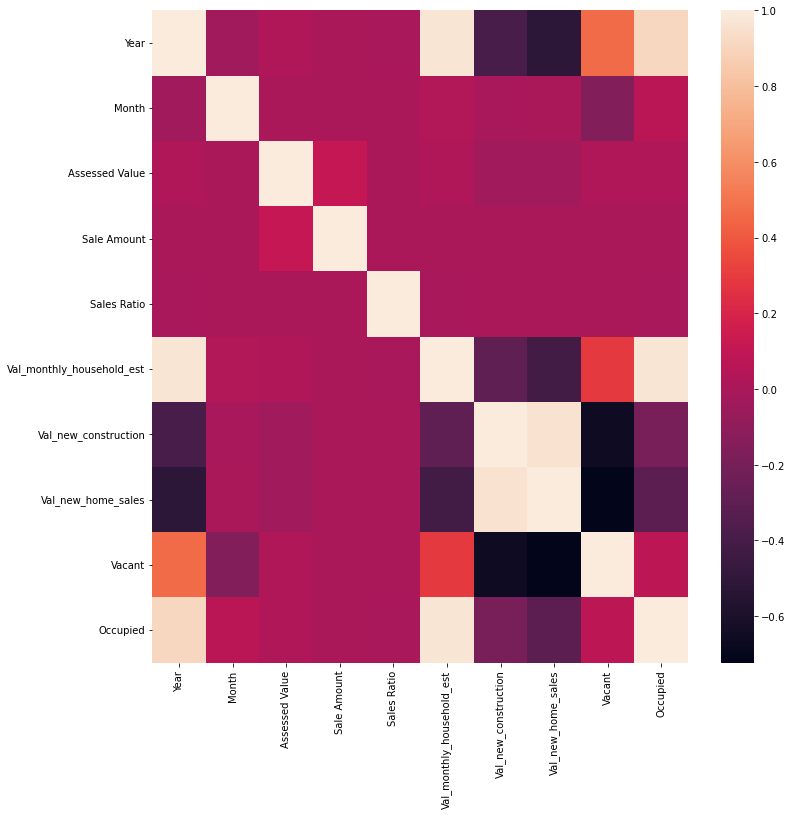

In [20]:
corr_matrix = data_max_prune_dropped.corr(numeric_only=True)
plt.figure(figsize=(12,12))
ax = sns.heatmap(corr_matrix)

### MISC

In [ ]:
# data.head()

# # Validation Prediction
# y_val_hat = clf.predict(X_val)
# validation_score = r2_score(y_val, y_val_hat)
# print("Validation R-squared:", validation_score)

# # Evaluate the final model's performance on the test set
# y_test_hat = clf.predict(X_test)
# test_score = r2_score(y_test, y_test_hat)
# print("Test R-squared:", test_score)


# Handle missing values (you can use other strategies)
# data = data.dropna()

#One-Hot Encoding Categorical Values With Managable Number of Unique Option (Possibility)
#data = pd.get_dummies(data, columns = ['Property Type', 'Residential Type'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Initialize and run TPOTRegressor for automated model selection with cross-validation
# tpot = TPOTRegressor(generations=2, population_size=50, random_state=42, n_jobs=-1, verbosity = 2, cv = 5)
# tpot.fit(X_train, y_train)

# # Evaluate the best pipeline on the test set
# test_score = tpot.score(X_test, y_test)
# print("Test R-squared:", test_score)

# # Get the best pipeline and export it as a Python script (if desired)
# best_pipeline = tpot.fitted_pipeline_
# best_pipeline.export('best_regression_pipeline.py')